# 通道策略
*用Python量化你的技术分析*

## 目录
- 通道是什么？
- 不同通道是怎么计算的？
- 通道如何用图表显示？
- 如何用通道构建策略？

## 通道是什么？
通道突破是技术分析中一个判断趋势的重要方法，其观念在于市场价格穿透了之前的价格压力或支撑，继而形成一股新的趋势，而交易策略的目标即是在突破发生时能够确认并建立仓位以获取趋势的利润。

## 不同通道是怎么计算的？
---
### 1. 均线百分比通道

$Upper = MA*1.03$

$lower = MA*0.97$

---

### 2. 布林带通道
$upper = MA+2\sigma$

$lower = MA-2\sigma$

---

### 3. 平均波幅通道
$upper = MA + ATR$

$lower = MA - ATR$

---

### 4. 高低价通道
$upper = Max(High,20)$

$lower = Min(low,20)$

## 通道如何用图表显示？

In [1]:
from jaqs.data import DataView
from jaqs.data import RemoteDataService
import os
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

dataview_folder = '../JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


In [2]:
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df
data = change_index(dv.get_ts('close_adj').loc[20170105:])

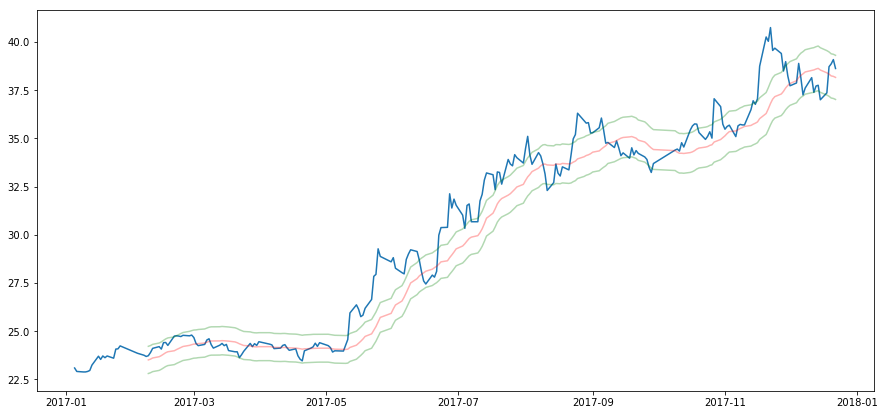

In [3]:
#均线百分比通道
middleband = ta.abstract.MA(data, timeperiod=20, price='600036.SH')
upperband = middleband*1.03
lowerband = middleband*0.97
data_B = pd.concat([middleband, upperband , lowerband], axis=1)
data_B.columns = ['middleband','upperband','lowerband']

plt.figure(figsize=(15,7))
plt.plot(data['600036.SH'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

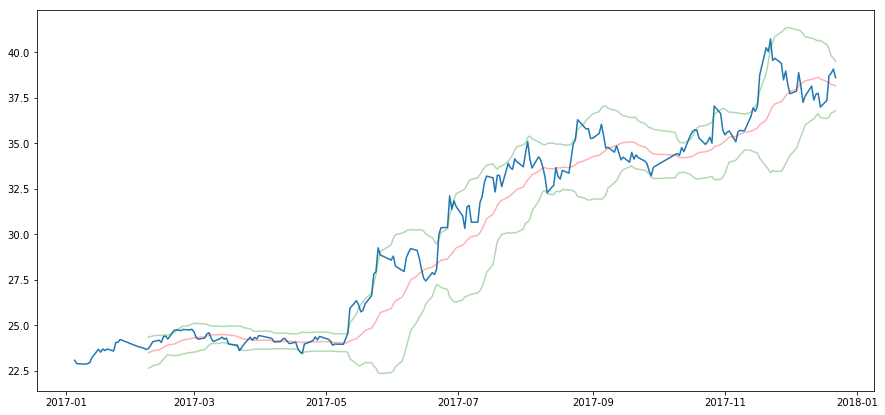

In [4]:
#布林带
data_B= ta.abstract.BBANDS(data, timeperiod=20, price='600036.SH')

plt.figure(figsize=(15,7))
plt.plot(data['600036.SH'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

In [5]:
high = change_index(dv.get_ts('high_adj').loc[20170105:])['600036.SH']
low = change_index(dv.get_ts('low_adj').loc[20170105:])['600036.SH']

In [6]:
stock = pd.concat([high,low,data['600036.SH']],axis=1)
stock.columns=['high','low','close']

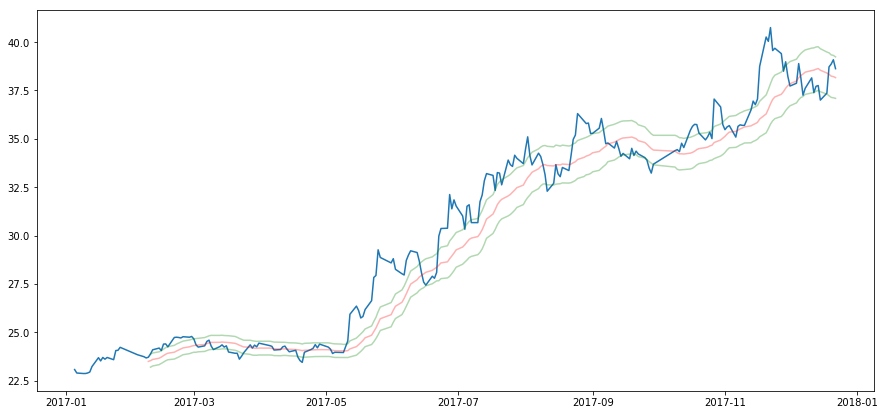

In [7]:
#平均波幅率通道线
atr = ta.abstract.ATR(stock, 20)
middleband = ta.abstract.MA(data, 20, price='600036.SH')
upperband = middleband + atr
lowerband = middleband - atr
data_B = pd.concat([middleband, upperband, lowerband], axis=1)
data_B.columns = ['middleband', 'upperband', 'lowerband']

plt.figure(figsize=(15,7))
plt.plot(data['600036.SH'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

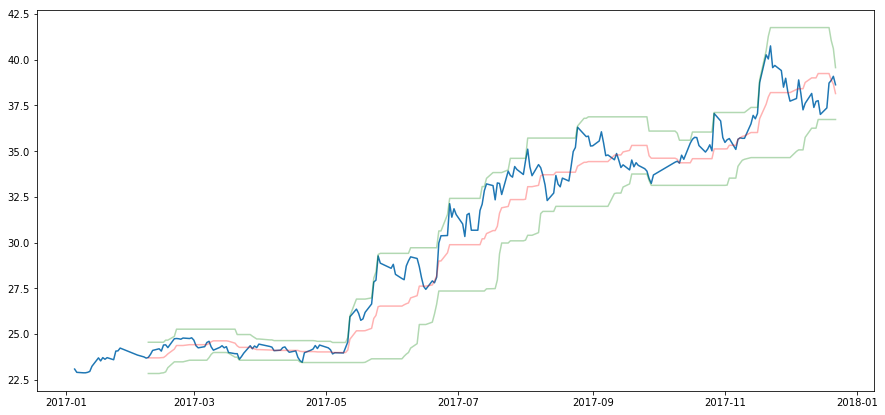

In [8]:
#高低价通道
upperband = ta.abstract.MAX(stock, 20, price='high')
lowerband = ta.abstract.MIN(stock, 20, price='low')
middleband = (upperband+lowerband)/2
data_B = pd.concat([middleband, upperband, lowerband], axis=1)
data_B.columns = ['middleband', 'upperband', 'lowerband']

plt.figure(figsize=(15,7))
plt.plot(data['600036.SH'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

## 如何用通道构建策略？
### 1. Bollinger Band

Buy： 价格突破UpperBand 和 Sigma<0.005

Sell： b%>0.05

### 2. ATR Band

Buy ： 价格突破upperBand

Sell: 价格跌穿lowerband

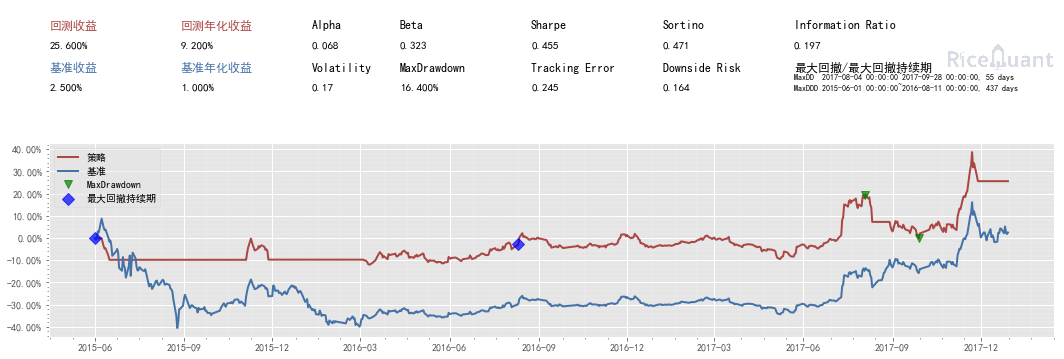

{'sys_analyser': {'benchmark_portfolio':                  cash  market_value  static_unit_net_value  total_value  \
  date                                                                      
  2015-06-01      1.300    999998.700                  1.000  1000000.000   
  2015-06-02      1.300    991822.610                  1.000   991823.910   
  2015-06-03      1.300    995596.190                  0.992   995597.490   
  2015-06-04      1.300   1029558.410                  0.996  1029559.710   
  2015-06-05      1.300   1025155.900                  1.030  1025157.200   
  2015-06-08      1.300   1087419.970                  1.025  1087421.270   
  2015-06-09      1.300   1067923.140                  1.087  1067924.440   
  2015-06-10      1.300   1049055.240                  1.068  1049056.540   
  2015-06-11      1.300   1036476.640                  1.049  1036477.940   
  2015-06-12      1.300   1038363.430                  1.036  1038364.730   
  2015-06-15      1.300   1001256.560

In [9]:
# Bollinger Band
import rqalpha
from rqalpha.api import *
import talib

def init(context):
    context.s1 = "000001.XSHE"
    context.PERIOD = 20

def handle_bar(context, bar_dict):
    
    prices = history_bars(context.s1, context.PERIOD+2, '1d', 'close')
    upperband, middleband, lowerband = talib.BBANDS(prices, context.PERIOD)
    sigma = (upperband[-1]-prices[-1])/(2*prices[-1])

    cur_position = context.portfolio.positions[context.s1].quantity
    shares = context.portfolio.cash/bar_dict[context.s1].close

    if sigma>0.05 and cur_position > 0:
        order_target_value(context.s1, 0)

    if prices[-2]<=upperband[-2] and prices[-1]>=upperband[-1] and sigma<0.005:
        order_shares(context.s1, shares)

config = {
  "base": {
    "start_date": "2015-06-01",
    "end_date": "2017-12-30",
    "accounts": {'stock':1000000},
    "benchmark": "000001.XSHE"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

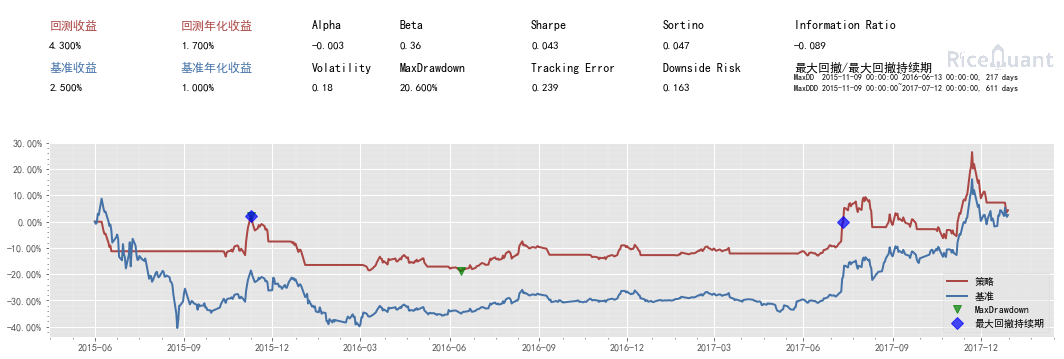

{'sys_analyser': {'benchmark_portfolio':                  cash  market_value  static_unit_net_value  total_value  \
  date                                                                      
  2015-06-01      1.300    999998.700                  1.000  1000000.000   
  2015-06-02      1.300    991822.610                  1.000   991823.910   
  2015-06-03      1.300    995596.190                  0.992   995597.490   
  2015-06-04      1.300   1029558.410                  0.996  1029559.710   
  2015-06-05      1.300   1025155.900                  1.030  1025157.200   
  2015-06-08      1.300   1087419.970                  1.025  1087421.270   
  2015-06-09      1.300   1067923.140                  1.087  1067924.440   
  2015-06-10      1.300   1049055.240                  1.068  1049056.540   
  2015-06-11      1.300   1036476.640                  1.049  1036477.940   
  2015-06-12      1.300   1038363.430                  1.036  1038364.730   
  2015-06-15      1.300   1001256.560

In [10]:
#ATR_Channel_1

import rqalpha
from rqalpha.api import *
import talib

def init(context):
    context.s1 = "000001.XSHE"
    context.PERIOD = 20


def handle_bar(context, bar_dict):

    price = history_bars(context.s1, context.PERIOD+1, '1d', 'close')
    high = history_bars(context.s1, context.PERIOD+1, '1d', 'high')
    low = history_bars(context.s1, context.PERIOD+1, '1d', 'low')
    
    
    MA = talib.SMA(price, context.PERIOD)
    atr = talib.ATR(high,low,price,timeperiod=context.PERIOD)
    upperband = MA[-1]+atr[-1]
    lowerband = MA[-1]-atr[-1]
#     print upperband

    cur_position = context.portfolio.positions[context.s1].quantity
    shares = context.portfolio.cash/bar_dict[context.s1].close

    if price[-1] < lowerband and cur_position > 0:
        order_target_value(context.s1, 0)

    if price[-1] > upperband:
        order_shares(context.s1, shares)

config = {
  "base": {
    "start_date": "2015-06-01",
    "end_date": "2017-12-30",
    "accounts": {'stock':1000000},
    "benchmark": "000001.XSHE"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

# 作业：
写一个高低价通道突破策略